# ** IMPORT PACKAGES: **

In [1]:
# python peripherals
import os
import random
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

# scipy
import scipy.io
import scipy.stats as ss

# numpy
import numpy

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.ticker as ticker

# pytorch
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader

# ipython
from IPython.display import display, HTML

# deep signature
from deep_signature.utils import utils
from deep_signature.data_generation.curve_generation import LevelCurvesGenerator
from deep_signature.data_manipulation import curve_processing
from deep_signature.nn.datasets import DeepSignatureTupletsDataset
from deep_signature.nn.networks import DeepSignatureArcLengthNet
from deep_signature.nn.losses import ContrastiveLoss
from deep_signature.nn.trainers import ModelTrainer
from deep_signature.data_manipulation import curve_sampling
from deep_signature.data_manipulation import curve_processing

# common
from common import settings


# ** HELPER FUNCTIONS: **

In [2]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

# https://stackoverflow.com/questions/36074455/python-matplotlib-with-a-line-color-gradient-and-colorbar
def colorline(ax, x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = numpy.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = numpy.array([z])

    z = numpy.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    # ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = numpy.array([x, y]).T.reshape(-1, 1, 2)
    segments = numpy.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def plot_dist(ax, dist):
    x = numpy.array(range(dist.shape[0]))
    y = dist
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    colorline(ax=ax, x=x, y=y, cmap='hsv')

def plot_curve_sample(ax, curve, curve_sample, indices, zorder, point_size=10, alpha=1, cmap='hsv'):
    x = curve_sample[:, 0]
    y = curve_sample[:, 1]
    c = numpy.linspace(0.0, 1.0, curve.shape[0])

    ax.scatter(
        x=x,
        y=y,
        c=c[indices],
        s=point_size,
        cmap=cmap,
        alpha=alpha,
        norm=plt.Normalize(0.0, 1.0),
        zorder=zorder)

def plot_curve_section_center_point(ax, x, y, zorder, radius=1, color='white'):
    circle = plt.Circle((x, y), radius=radius, color=color, zorder=zorder)
    ax.add_artist(circle)

def plot_curve(ax, curve, linewidth=2, color='red', alpha=1):
    x = curve[:, 0]
    y = curve[:, 1]
    ax.plot(x, y, linewidth=linewidth, color=color, alpha=alpha)

def plot_curvature(ax, curvature, color='red', linewidth=2):
    x = range(curvature.shape[0])
    y = curvature
    ax.plot(x, y, color=color, linewidth=linewidth)

def plot_sample(ax, sample, color, zorder, point_size=10, alpha=1):
    x = sample[:, 0]
    y = sample[:, 1]

    ax.scatter(
        x=x,
        y=y,
        s=point_size,
        color=color,
        alpha=alpha,
        zorder=zorder)

def all_subdirs_of(b='.'):
  result = []
  for d in os.listdir(b):
    bd = os.path.join(b, d)
    if os.path.isdir(bd): result.append(bd)
  return result

# ** GLOBAL SETTINGS: **

In [3]:
plt.style.use("dark_background")

# ** SANITY CHECK - CURVES: **

In [ ]:
curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
limit = 10
color_map = plt.get_cmap('rainbow', limit)
for i, curve in enumerate(curves[:limit]): 
    fig, ax = plt.subplots(1, 1, figsize=(80,40))
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(30)
    ax.axis('equal')
    plot_curve(ax=ax, curve=curve, linewidth=5)
    plt.show()

# ** SANITY CHECK - DATASET PAIRS **

In [ ]:
dataset = DeepSignatureTupletsDataset()
dataset.load_dataset(dir_path=settings.level_curves_arclength_tuplets_dir_path)
dataset_size = len(dataset)
indices = list(range(dataset_size))
# numpy.random.shuffle(indices)
sampler = SubsetRandomSampler(indices)
data_loader = DataLoader(dataset, batch_size=1, sampler=sampler)

display(HTML('<h3>Random sample of tuplets:</h3>'))
for tuplet_index, data in enumerate(data_loader, 0):
    if tuplet_index == 35:
        break

    curve1 = torch.squeeze(torch.squeeze(data['input'])[0])
    curve2 = torch.squeeze(torch.squeeze(data['input'])[1])
    curve3 = torch.squeeze(torch.squeeze(data['input'])[2])
    # curve4 = torch.squeeze(torch.squeeze(data['input'])[3])

    display(HTML(f'<h3>Sample #{tuplet_index}:</h3>'))

    curve1 = curve1.cpu().numpy()
    curve2 = curve2.cpu().numpy()
    curve3 = curve3.cpu().numpy()
    # curve4 = curve4.cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.axis('equal')

    # print(data['curve'][0].shape)
    # print(data['anchor_indices'][0].cpu().numpy())
    # print(data['positive_indices1'][0].cpu().numpy())
    # print(data['positive_indices2'][0].cpu().numpy())

    # plot_curve(ax=ax, curve=data['curve'][0].cpu().numpy(), linewidth=2)

    plot_sample(
        ax=ax, 
        sample=curve1, 
        point_size=30,
        color='lightcoral',
        zorder=150)

    plot_sample(
        ax=ax, 
        sample=curve2, 
        point_size=20,
        color='skyblue',
        zorder=50)

    plot_sample(
        ax=ax, 
        sample=curve3, 
        point_size=20,
        color='springgreen',
        zorder=50)

    # print(curve1)
    # print(curve2)
    # print(curve3)

    # plot_sample(
    #     ax=ax, 
    #     sample=curve4, 
    #     point_size=50,
    #     color='gold',
    #     zorder=50)

    # plot_sample(ax, numpy.array([[0,0]]), point_size=50, alpha=1, color='white', zorder=100)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)
    
    plt.show()

# ** TRAIN/VALIDATION LOSS **

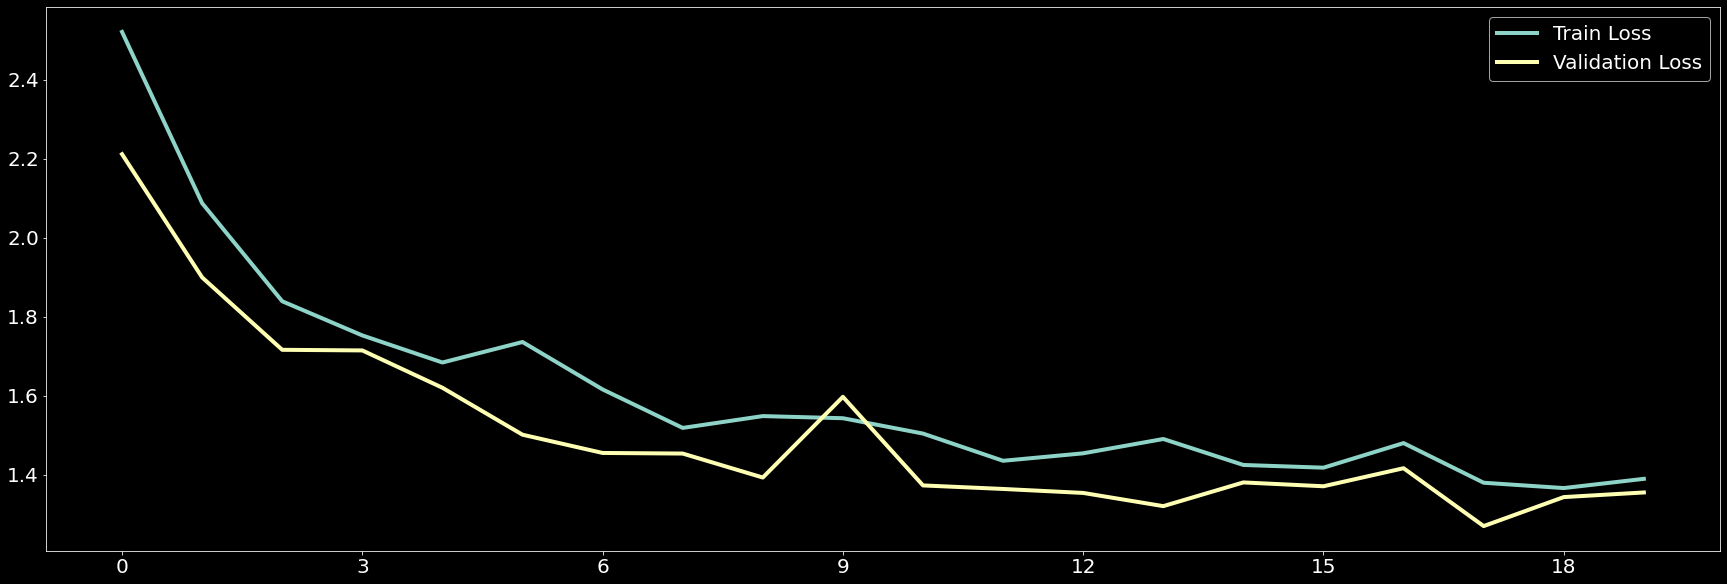

In [34]:
all_subdirs = all_subdirs_of(settings.level_curves_arclength_tuplets_results_dir_path)
latest_subdir = os.path.normpath(max(all_subdirs, key=os.path.getmtime))
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()

# results2 = numpy.load(f"C:/deep-signature-data/level-curves/results/tuplets/arclength/2021-01-14-02-42-52/results.npy", allow_pickle=True).item()

epochs = results['epochs']
batch_size = results['batch_size']
train_loss_array = results['train_loss_array'][1:]
validation_loss_array = results['validation_loss_array'][1:]

# train_loss_array2 = results2['train_loss_array']
# validation_loss_array2 = results2['validation_loss_array']

epochs_list = numpy.array(range(len(train_loss_array)))
# epochs_list2 = numpy.array(range(len(train_loss_array2)))

fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

ax.plot(epochs_list, train_loss_array, label='Train Loss', linewidth=4.0)
ax.plot(epochs_list, validation_loss_array, label='Validation Loss', linewidth=4.0)

# ax.plot(epochs_list2, train_loss_array2, label='Train Loss2', linewidth=4.0)
# ax.plot(epochs_list2, validation_loss_array2, label='Validation Loss2', linewidth=4.0)

plt.legend(fontsize=20, title_fontsize=20)

# print(train_loss_array)
# print(validation_loss_array)
plt.show()

# ** TEST MODEL **

------------ 4 + 5 -----------
[[0.09052395]]
[[0.21706597]]
[[0.1810479]]
-----------------------
[[0.08830606]]
[[0.12612232]]
[[0.21442838]]
[[0.21317204]]
-----------------------
[[0.0906026]]
[[0.09266146]]
[[0.09445024]]
[[0.09744582]]
[[0.10017263]]
[[0.10328138]]
[[0.10676626]]
[[0.1096997]]
[[0.11297923]]
[[0.11538855]]
[[0.12086301]]
[[0.12246148]]
[[0.1281709]]
[[0.13109503]]
[[0.1356814]]
[[0.13830188]]
[[0.14161976]]
[[0.14502266]]
[[0.14828621]]
[[0.15126508]]
[[0.15401142]]
[[0.15878633]]
[[0.16080913]]
[[0.16625317]]
[[0.1658984]]
[[0.17017668]]
[[0.17557738]]
[[0.17860721]]
[[0.18104242]]
[[0.18681133]]
[[0.18649264]]
[[0.1897459]]
[[0.19652322]]
[[0.19952546]]
[[0.20220915]]
[[0.20528138]]
[[0.20994523]]
[[0.21115306]]
[[0.21377346]]
[[0.22059159]]
[[0.21952299]]
[[0.22439146]]
[[0.22678647]]
[[0.2307534]]
[[0.22699041]]
[[0.23731247]]
[[0.23656894]]
[[0.24234221]]
[[0.24318336]]
[[0.24645577]]
[[0.24689367]]
[[0.25318839]]
[[0.25362968]]
[[0.2573475]]
[[0.26142772]]


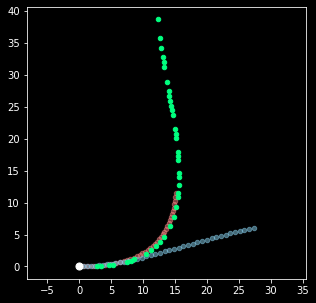

------------ 4 + 5 -----------
[[0.14304316]]
[[0.2909911]]
[[0.28608632]]
-----------------------
[[0.13954539]]
[[0.14344994]]
[[0.28299533]]
[[0.28090806]]
-----------------------
[[0.14300895]]
[[0.14684884]]
[[0.14994177]]
[[0.15365114]]
[[0.15656408]]
[[0.16023631]]
[[0.16311783]]
[[0.16774223]]
[[0.16998089]]
[[0.17498048]]
[[0.17802947]]
[[0.18053705]]
[[0.18618928]]
[[0.19043274]]
[[0.19198647]]
[[0.19755603]]
[[0.20051437]]
[[0.20561736]]
[[0.2066666]]
[[0.21076206]]
[[0.2184451]]
[[0.2163516]]
[[0.22674776]]
[[0.22808741]]
[[0.23209177]]
[[0.23531092]]
[[0.23763183]]
[[0.2401909]]
[[0.24591299]]
[[0.24983742]]
[[0.25419094]]
[[0.25550715]]
[[0.25948286]]
[[0.26529688]]
[[0.26879451]]
[[0.27424905]]
[[0.27642262]]
[[0.28036502]]
[[0.28236986]]
[[0.28731999]]
[[0.28958148]]
[[0.29315092]]
[[0.29830424]]
[[0.30090747]]
[[0.3031123]]
[[0.30884364]]
[[0.31058059]]
[[0.31565939]]
[[0.31858394]]
[[0.31974259]]
[[0.31976719]]
[[0.32719192]]
[[0.32859063]]
[[0.33362381]]
[[0.33415972

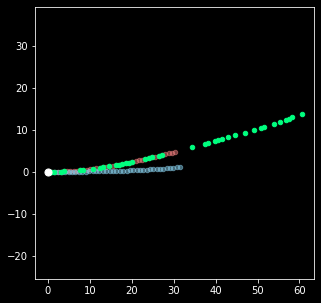

------------ 4 + 5 -----------
[[0.15112722]]
[[0.30302914]]
[[0.30225444]]
-----------------------
[[0.14746832]]
[[0.14803172]]
[[0.29550004]]
[[0.29497771]]
-----------------------
[[0.15044854]]
[[0.15462536]]
[[0.15762323]]
[[0.16107653]]
[[0.16465691]]
[[0.16821544]]
[[0.17150498]]
[[0.17612897]]
[[0.17892067]]
[[0.18299399]]
[[0.18672364]]
[[0.19220833]]
[[0.1940966]]
[[0.19754434]]
[[0.20473574]]
[[0.20721161]]
[[0.21043772]]
[[0.21440492]]
[[0.22014879]]
[[0.2227269]]
[[0.22721251]]
[[0.23068587]]
[[0.23436168]]
[[0.23606972]]
[[0.24145578]]
[[0.24353608]]
[[0.24959422]]
[[0.25306869]]
[[0.25785533]]
[[0.25851808]]
[[0.26406611]]
[[0.27118963]]
[[0.27074099]]
[[0.27566641]]
[[0.28076606]]
[[0.28348604]]
[[0.2889935]]
[[0.29065475]]
[[0.29854473]]
[[0.29913444]]
[[0.30371513]]
[[0.30658668]]
[[0.31164788]]
[[0.31660207]]
[[0.31701077]]
[[0.32273253]]
[[0.32524678]]
[[0.3262535]]
[[0.33144599]]
[[0.33477099]]
[[0.33980786]]
[[0.3407078]]
[[0.34692774]]
[[0.34948124]]
[[0.3548024

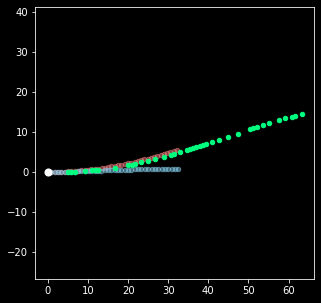

------------ 4 + 5 -----------
[[0.12384314]]
[[0.27271432]]
[[0.24768628]]
-----------------------
[[0.12085426]]
[[0.14529963]]
[[0.2661539]]
[[0.26793659]]
-----------------------
[[0.12435691]]
[[0.12837391]]
[[0.13189248]]
[[0.13542548]]
[[0.13836156]]
[[0.14205997]]
[[0.14413137]]
[[0.14842701]]
[[0.15194354]]
[[0.15564858]]
[[0.16087742]]
[[0.16175028]]
[[0.1656333]]
[[0.16974153]]
[[0.17259104]]
[[0.17678756]]
[[0.18117293]]
[[0.18521624]]
[[0.189934]]
[[0.19201961]]
[[0.19942758]]
[[0.20060205]]
[[0.20515814]]
[[0.20795081]]
[[0.21214445]]
[[0.21696914]]
[[0.21986357]]
[[0.22379346]]
[[0.22645442]]
[[0.23233468]]
[[0.23521687]]
[[0.2376367]]
[[0.2453683]]
[[0.24602119]]
[[0.25025178]]
[[0.25520138]]
[[0.25899644]]
[[0.26106766]]
[[0.26626529]]
[[0.27134106]]
[[0.27459479]]
[[0.27781734]]
[[0.2794064]]
[[0.28200626]]
[[0.28965408]]
[[0.28941762]]
[[0.29495143]]
[[0.29851131]]
[[0.30173851]]
[[0.30842479]]
[[0.30386425]]
[[0.31460053]]
[[0.31942777]]
[[0.31881266]]
[[0.32353022]

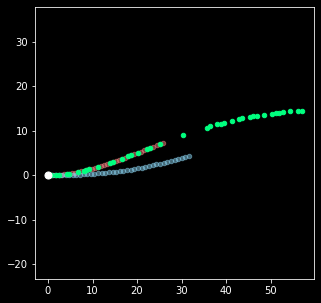

------------ 4 + 5 -----------
[[0.15997387]]
[[0.31527886]]
[[0.31994775]]
-----------------------
[[0.15613412]]
[[0.15205377]]
[[0.3081879]]
[[0.31150292]]
-----------------------
[[0.15989092]]
[[0.16369818]]
[[0.16698286]]
[[0.17058638]]
[[0.1747899]]
[[0.17884163]]
[[0.18303502]]
[[0.18648301]]
[[0.19098571]]
[[0.19264153]]
[[0.19800423]]
[[0.20198396]]
[[0.20588405]]
[[0.21291194]]
[[0.21827026]]
[[0.22413019]]
[[0.22804083]]
[[0.22813357]]
[[0.23453138]]
[[0.23881568]]
[[0.24250994]]
[[0.24580383]]
[[0.24635859]]
[[0.25177173]]
[[0.25594511]]
[[0.26057219]]
[[0.26479873]]
[[0.26994207]]
[[0.2711515]]
[[0.27394603]]
[[0.28125794]]
[[0.28407983]]
[[0.28856636]]
[[0.29326387]]
[[0.29718133]]
[[0.30075377]]
[[0.30227594]]
[[0.30817138]]
[[0.30896565]]
[[0.31237828]]
[[0.31473824]]
[[0.32063515]]
[[0.32195496]]
[[0.32583192]]
[[0.33022492]]
[[0.33265081]]
[[0.33464576]]
[[0.33934048]]
[[0.34176206]]
[[0.34484068]]
[[0.34860549]]
[[0.34930853]]
[[0.35512242]]
[[0.35432559]]
[[0.35719

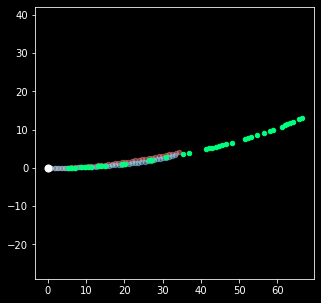

------------ 4 + 5 -----------
[[0.15213048]]
[[0.29068484]]
[[0.30426097]]
-----------------------
[[0.14880845]]
[[0.13570076]]
[[0.28450921]]
[[0.28474127]]
-----------------------
[[0.15202188]]
[[0.15557461]]
[[0.15862195]]
[[0.16233494]]
[[0.16587271]]
[[0.16908087]]
[[0.17296359]]
[[0.17563087]]
[[0.17981061]]
[[0.18375723]]
[[0.18739955]]
[[0.19084514]]
[[0.19452897]]
[[0.19570209]]
[[0.20187615]]
[[0.20415417]]
[[0.20875749]]
[[0.21463555]]
[[0.2167489]]
[[0.21802225]]
[[0.22233187]]
[[0.22763548]]
[[0.23109372]]
[[0.23414386]]
[[0.23803141]]
[[0.2402322]]
[[0.24219227]]
[[0.24406816]]
[[0.25220562]]
[[0.25508476]]
[[0.25742013]]
[[0.262016]]
[[0.26644331]]
[[0.26879108]]
[[0.27365143]]
[[0.27332841]]
[[0.27736815]]
[[0.28003241]]
[[0.28250729]]
[[0.28762762]]
[[0.28950846]]
[[0.29194859]]
[[0.29702901]]
[[0.30006065]]
[[0.30338932]]
[[0.30596778]]
[[0.30711617]]
[[0.3116246]]
[[0.31620636]]
[[0.31794819]]
[[0.3184676]]
[[0.32459232]]
[[0.32627949]]
[[0.33088976]]
[[0.33426755

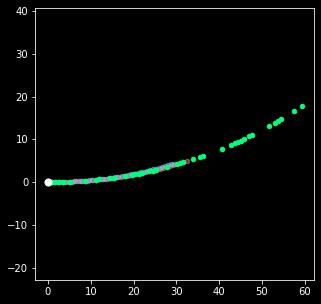

------------ 4 + 5 -----------
[[0.13831556]]
[[0.27039255]]
[[0.27663111]]
-----------------------
[[0.13514556]]
[[0.13120268]]
[[0.26634825]]
[[0.26668141]]
-----------------------
[[0.13840567]]
[[0.14159526]]
[[0.1453752]]
[[0.14807521]]
[[0.15085306]]
[[0.15395537]]
[[0.15817282]]
[[0.16043721]]
[[0.16349753]]
[[0.16651597]]
[[0.17056949]]
[[0.17079621]]
[[0.17803459]]
[[0.17938873]]
[[0.18399534]]
[[0.18758234]]
[[0.19166001]]
[[0.19363326]]
[[0.19636018]]
[[0.19977719]]
[[0.20266737]]
[[0.20602331]]
[[0.21042338]]
[[0.2124046]]
[[0.21779243]]
[[0.22324223]]
[[0.22457909]]
[[0.22874998]]
[[0.23016216]]
[[0.23488772]]
[[0.23917456]]
[[0.24156189]]
[[0.24581403]]
[[0.2483692]]
[[0.25396063]]
[[0.25572589]]
[[0.25932484]]
[[0.26114164]]
[[0.26472604]]
[[0.27113949]]
[[0.27295671]]
[[0.27882796]]
[[0.28176217]]
[[0.28362124]]
[[0.28564449]]
[[0.29030786]]
[[0.29262142]]
[[0.29653539]]
[[0.29908765]]
[[0.30234581]]
[[0.3026257]]
[[0.30809945]]
[[0.31020701]]
[[0.31497589]]
[[0.316369

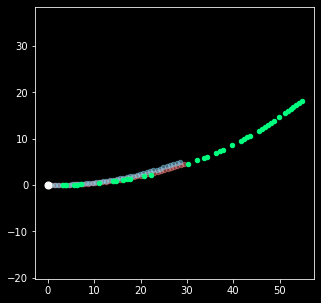

------------ 4 + 5 -----------
[[0.13593731]]
[[0.27004098]]
[[0.27187463]]
-----------------------
[[0.13281087]]
[[0.13067064]]
[[0.26348151]]
[[0.26495354]]
-----------------------
[[0.13596009]]
[[0.13917351]]
[[0.14229615]]
[[0.14621265]]
[[0.14875412]]
[[0.15189403]]
[[0.15467633]]
[[0.15791559]]
[[0.16018504]]
[[0.16602444]]
[[0.16805771]]
[[0.17346615]]
[[0.17626377]]
[[0.18088527]]
[[0.18406087]]
[[0.18843103]]
[[0.18993058]]
[[0.19343384]]
[[0.19800152]]
[[0.20284142]]
[[0.20365673]]
[[0.20716488]]
[[0.21155902]]
[[0.21480637]]
[[0.2164066]]
[[0.22146823]]
[[0.22103456]]
[[0.22690322]]
[[0.23030826]]
[[0.23569106]]
[[0.23714736]]
[[0.24016199]]
[[0.24676753]]
[[0.24504889]]
[[0.25284078]]
[[0.2562382]]
[[0.25826387]]
[[0.262277]]
[[0.26338074]]
[[0.26843233]]
[[0.26947224]]
[[0.27159923]]
[[0.27522899]]
[[0.27888397]]
[[0.28085493]]
[[0.28076894]]
[[0.28677078]]
[[0.29209615]]
[[0.29322808]]
[[0.29587701]]
[[0.30071892]]
[[0.30113353]]
[[0.30381934]]
[[0.30917964]]
[[0.312946

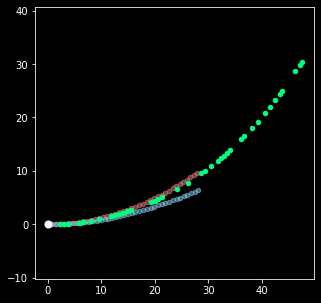

------------ 4 + 5 -----------
[[0.13620645]]
[[0.27296757]]
[[0.27241289]]
-----------------------
[[0.13294148]]
[[0.1335284]]
[[0.26646988]]
[[0.26657306]]
-----------------------
[[0.13617786]]
[[0.13933431]]
[[0.14199734]]
[[0.14456393]]
[[0.14969591]]
[[0.15229242]]
[[0.15459861]]
[[0.15628584]]
[[0.16045488]]
[[0.16535243]]
[[0.16775604]]
[[0.17077997]]
[[0.17548601]]
[[0.17880246]]
[[0.18229062]]
[[0.18594418]]
[[0.18957193]]
[[0.19478149]]
[[0.19853907]]
[[0.20056578]]
[[0.20132192]]
[[0.20685975]]
[[0.21144332]]
[[0.21441754]]
[[0.21858163]]
[[0.22202032]]
[[0.22518562]]
[[0.23076778]]
[[0.23247595]]
[[0.23381375]]
[[0.23881546]]
[[0.23982902]]
[[0.24532262]]
[[0.25024415]]
[[0.25376179]]
[[0.25726907]]
[[0.25893779]]
[[0.26205116]]
[[0.26532582]]
[[0.26712449]]
[[0.27727817]]
[[0.27831318]]
[[0.2803474]]
[[0.28266592]]
[[0.28594049]]
[[0.2894555]]
[[0.29227503]]
[[0.2941822]]
[[0.29876063]]
[[0.30291777]]
[[0.30856591]]
[[0.31092698]]
[[0.31105709]]
[[0.31382261]]
[[0.317925

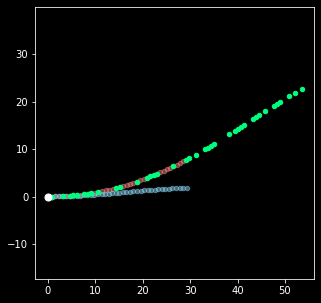

------------ 4 + 5 -----------
[[0.08249333]]
[[0.15581779]]
[[0.16498666]]
-----------------------
[[0.07967177]]
[[0.07426436]]
[[0.15393613]]
[[0.155823]]
-----------------------
[[0.08231887]]
[[0.08441529]]
[[0.08766906]]
[[0.09008134]]
[[0.09296778]]
[[0.09592212]]
[[0.09966069]]
[[0.10176831]]
[[0.10588047]]
[[0.10665673]]
[[0.10915286]]
[[0.11351991]]
[[0.11732987]]
[[0.11837125]]
[[0.11745367]]
[[0.1239148]]
[[0.12474522]]
[[0.12644044]]
[[0.13200163]]
[[0.13223623]]
[[0.13145264]]
[[0.13541738]]
[[0.13756278]]
[[0.14083185]]
[[0.14228071]]
[[0.14555584]]
[[0.14345557]]
[[0.14842593]]
[[0.1449845]]
[[0.14908457]]
[[0.15351137]]
[[0.14823143]]
[[0.15141461]]
[[0.14957913]]
[[0.1513866]]
[[0.1568328]]
[[0.15439554]]
[[0.15960384]]
[[0.15805314]]
[[0.15867739]]
[[0.15280508]]
[[0.15841288]]
[[0.15716]]
[[0.16025496]]
[[0.16017449]]
[[0.15881093]]
[[0.15844883]]
[[0.16698423]]
[[0.15961251]]
[[0.16559072]]
[[0.16865172]]
[[0.15938117]]
[[0.16833574]]
[[0.16350259]]
[[0.16409227]]


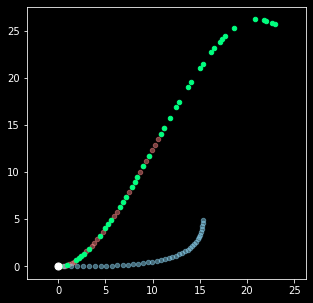

------------ 4 + 5 -----------
[[0.12238565]]
[[0.2501212]]
[[0.2447713]]
-----------------------
[[0.11928975]]
[[0.1216036]]
[[0.24089334]]
[[0.24181847]]
-----------------------
[[0.12240817]]
[[0.12553205]]
[[0.12876895]]
[[0.13235194]]
[[0.13505149]]
[[0.13699074]]
[[0.14042556]]
[[0.14337621]]
[[0.14654682]]
[[0.14849826]]
[[0.15291557]]
[[0.1551224]]
[[0.15750051]]
[[0.16110135]]
[[0.16478711]]
[[0.16780385]]
[[0.16957623]]
[[0.17402755]]
[[0.17892342]]
[[0.17970489]]
[[0.18147883]]
[[0.18735052]]
[[0.19142569]]
[[0.19439377]]
[[0.19760792]]
[[0.20117715]]
[[0.20280198]]
[[0.20598433]]
[[0.2111807]]
[[0.21380964]]
[[0.21450606]]
[[0.21887155]]
[[0.22000853]]
[[0.22507456]]
[[0.22727094]]
[[0.23065853]]
[[0.23519476]]
[[0.23436454]]
[[0.24249191]]
[[0.24511303]]
[[0.24831082]]
[[0.25239559]]
[[0.25311739]]
[[0.25624124]]
[[0.26041107]]
[[0.26369355]]
[[0.26740066]]
[[0.27215469]]
[[0.27607092]]
[[0.27311999]]
[[0.28346524]]
[[0.28817856]]
[[0.28545712]]
[[0.28984423]]
[[0.2980666

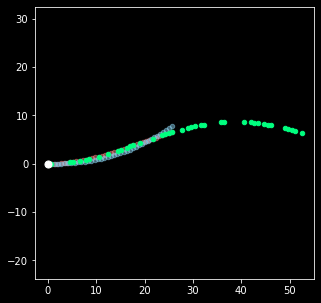

------------ 4 + 5 -----------
[[0.0994971]]
[[0.23399595]]
[[0.19899419]]
-----------------------
[[0.09650388]]
[[0.1336127]]
[[0.23011658]]
[[0.22913933]]
-----------------------
[[0.09948605]]
[[0.1026586]]
[[0.10564422]]
[[0.1095846]]
[[0.11195165]]
[[0.11490811]]
[[0.11911003]]
[[0.12253857]]
[[0.12573816]]
[[0.12900168]]
[[0.13145454]]
[[0.1366325]]
[[0.13842991]]
[[0.14252363]]
[[0.14785391]]
[[0.15004401]]
[[0.15272944]]
[[0.15280136]]
[[0.16135533]]
[[0.16549896]]
[[0.17092815]]
[[0.17479299]]
[[0.1794302]]
[[0.18180324]]
[[0.18507632]]
[[0.18653793]]
[[0.19354966]]
[[0.19365887]]
[[0.19698312]]
[[0.19898711]]
[[0.20271302]]
[[0.2079764]]
[[0.21278043]]
[[0.21347423]]
[[0.21835828]]
[[0.22008135]]
[[0.22210511]]
[[0.22593603]]
[[0.2292853]]
[[0.23019812]]
[[0.23228577]]
[[0.23585466]]
[[0.24020821]]
[[0.24594645]]
[[0.24551377]]
[[0.24938765]]
[[0.25432753]]
[[0.25252603]]
[[0.25919235]]
[[0.25714879]]
[[0.26017449]]
[[0.26280035]]
[[0.26778046]]
[[0.26699553]]
[[0.27429758]]

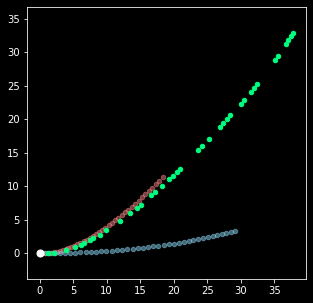

------------ 4 + 5 -----------
[[0.07992084]]
[[0.21920777]]
[[0.15984168]]
-----------------------
[[0.0769113]]
[[0.13734689]]
[[0.21425819]]
[[0.21773013]]
-----------------------
[[0.08046112]]
[[0.08329027]]
[[0.08722589]]
[[0.09007381]]
[[0.0933668]]
[[0.09718179]]
[[0.10048815]]
[[0.10621197]]
[[0.10807376]]
[[0.11617539]]
[[0.1176611]]
[[0.11978314]]
[[0.12467553]]
[[0.1269144]]
[[0.13408606]]
[[0.13398517]]
[[0.13993924]]
[[0.14376099]]
[[0.14356058]]
[[0.15589423]]
[[0.15815414]]
[[0.16184699]]
[[0.16338011]]
[[0.16292575]]
[[0.16973566]]
[[0.1788526]]
[[0.17567969]]
[[0.17868805]]
[[0.18191566]]
[[0.18522346]]
[[0.18538889]]
[[0.19123367]]
[[0.19686886]]
[[0.19839184]]
[[0.20105707]]
[[0.20192698]]
[[0.20598992]]
[[0.20651943]]
[[0.20500601]]
[[0.21302499]]
[[0.21180536]]
[[0.21538393]]
[[0.2211517]]
[[0.23294457]]
[[0.22986506]]
[[0.22478786]]
[[0.2231779]]
[[0.23675904]]
[[0.24370644]]
[[0.24779925]]
[[0.24372741]]
[[0.23459684]]
[[0.24083074]]
[[0.24739744]]
[[0.24323599]

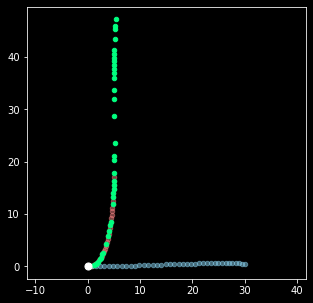

------------ 4 + 5 -----------
[[0.09201064]]
[[0.18314487]]
[[0.18402129]]
-----------------------
[[0.08941567]]
[[0.08875919]]
[[0.17817486]]
[[0.17736473]]
-----------------------
[[0.091716]]
[[0.09379771]]
[[0.09652809]]
[[0.0990809]]
[[0.10019757]]
[[0.10313146]]
[[0.10485249]]
[[0.10869756]]
[[0.10942052]]
[[0.11338608]]
[[0.11498074]]
[[0.11480598]]
[[0.1202363]]
[[0.12091587]]
[[0.12334573]]
[[0.125307]]
[[0.12849766]]
[[0.129836]]
[[0.13186626]]
[[0.13632299]]
[[0.13825146]]
[[0.13927244]]
[[0.1420013]]
[[0.14676996]]
[[0.14847214]]
[[0.14892359]]
[[0.15231032]]
[[0.15536235]]
[[0.15837712]]
[[0.16193214]]
[[0.1621934]]
[[0.16075182]]
[[0.16529789]]
[[0.17166211]]
[[0.16957112]]
[[0.17284423]]
[[0.17721957]]
[[0.17637886]]
[[0.17631706]]
[[0.18074362]]
[[0.18233311]]
[[0.18454737]]
[[0.18438541]]
[[0.19072351]]
[[0.19063063]]
[[0.19209587]]
[[0.19707487]]
[[0.1935548]]
[[0.19893218]]
[[0.20056922]]
[[0.20538613]]
[[0.20153155]]
[[0.20719398]]
[[0.21006596]]
[[0.21272717]]
[[

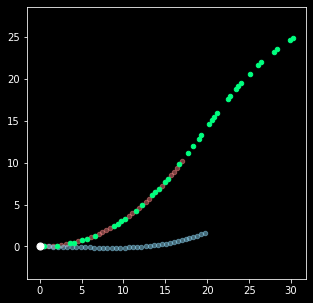

------------ 4 + 5 -----------
[[0.06734791]]
[[0.13573565]]
[[0.13469581]]
-----------------------
[[0.06562741]]
[[0.06526197]]
[[0.13088937]]
[[0.12984351]]
-----------------------
[[0.06742853]]
[[0.06906608]]
[[0.07081303]]
[[0.07194335]]
[[0.07297599]]
[[0.07529491]]
[[0.07750795]]
[[0.07693154]]
[[0.08073715]]
[[0.08248717]]
[[0.08376893]]
[[0.086168]]
[[0.08505821]]
[[0.08965675]]
[[0.09056815]]
[[0.09135564]]
[[0.09287498]]
[[0.09636442]]
[[0.09512819]]
[[0.09800106]]
[[0.10014872]]
[[0.10232544]]
[[0.10297481]]
[[0.10397289]]
[[0.10641334]]
[[0.10712296]]
[[0.10958626]]
[[0.11103048]]
[[0.11023325]]
[[0.11612482]]
[[0.11381837]]
[[0.11766]]
[[0.11984269]]
[[0.12193287]]
[[0.12352688]]
[[0.12450161]]
[[0.12796097]]
[[0.12702717]]
[[0.13047466]]
[[0.1333048]]
[[0.1349278]]
[[0.13493423]]
[[0.13921107]]
[[0.13936513]]
[[0.14026629]]
[[0.14252941]]
[[0.1433276]]
[[0.14516213]]
[[0.14609922]]
[[0.14921896]]
[[0.14851937]]
[[0.15192916]]
[[0.15166895]]
[[0.15582258]]
[[0.15410291]]

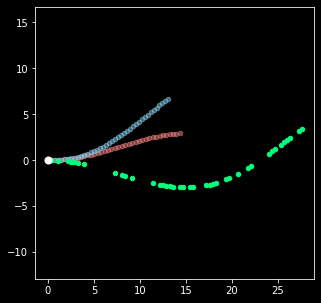

------------ 4 + 5 -----------
[[0.1680848]]
[[0.32059414]]
[[0.33616961]]
-----------------------
[[0.16377287]]
[[0.14898074]]
[[0.3127536]]
[[0.31487774]]
-----------------------
[[0.16692954]]
[[0.1715216]]
[[0.17544481]]
[[0.17945647]]
[[0.18340159]]
[[0.18783426]]
[[0.19095411]]
[[0.19533906]]
[[0.19845407]]
[[0.2024407]]
[[0.20879709]]
[[0.21552481]]
[[0.21776752]]
[[0.22253897]]
[[0.22676864]]
[[0.22873978]]
[[0.2360371]]
[[0.23839754]]
[[0.24270689]]
[[0.24379068]]
[[0.24950587]]
[[0.25413324]]
[[0.25727202]]
[[0.26127587]]
[[0.2639657]]
[[0.2695821]]
[[0.27113505]]
[[0.27593091]]
[[0.27883277]]
[[0.28563161]]
[[0.28675759]]
[[0.28899443]]
[[0.29275627]]
[[0.29668855]]
[[0.3008562]]
[[0.30438423]]
[[0.3079589]]
[[0.31230883]]
[[0.31444419]]
[[0.31928819]]
[[0.31867584]]
[[0.32517675]]
[[0.32728678]]
[[0.33061783]]
[[0.33361581]]
[[0.33514712]]
[[0.33453185]]
[[0.34273891]]
[[0.34626435]]
[[0.3461072]]
[[0.3508309]]
[[0.35565715]]
[[0.36219103]]
[[0.36098895]]
[[0.36226014]]
[[

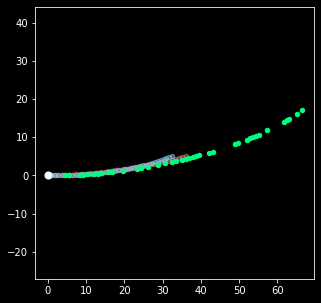

------------ 4 + 5 -----------
[[0.06243659]]
[[0.17865386]]
[[0.12487318]]
-----------------------
[[0.06119154]]
[[0.11005861]]
[[0.17125015]]
[[0.17148297]]
-----------------------
[[0.06262554]]
[[0.0629743]]
[[0.06445693]]
[[0.06527911]]
[[0.0664606]]
[[0.0674277]]
[[0.06987429]]
[[0.07035738]]
[[0.07244114]]
[[0.07635853]]
[[0.08018388]]
[[0.08126491]]
[[0.08613474]]
[[0.09099934]]
[[0.09793239]]
[[0.09274109]]
[[0.10173343]]
[[0.10706606]]
[[0.11075469]]
[[0.11292116]]
[[0.11558953]]
[[0.11843211]]
[[0.12457814]]
[[0.12707033]]
[[0.13142363]]
[[0.13450272]]
[[0.13563904]]
[[0.13926841]]
[[0.14561211]]
[[0.15067492]]
[[0.14952402]]
[[0.15433235]]
[[0.15363811]]
[[0.16020395]]
[[0.16346031]]
[[0.16394135]]
[[0.16830828]]
[[0.16498033]]
[[0.17011946]]
[[0.17258778]]
[[0.17598086]]
[[0.1788329]]
[[0.18430817]]
[[0.1859106]]
[[0.18813221]]
[[0.18693565]]
[[0.19429935]]
[[0.19400001]]
[[0.19930472]]
[[0.20199136]]
[[0.19546463]]
[[0.20198965]]
[[0.20714628]]
[[0.20964888]]
[[0.2104033

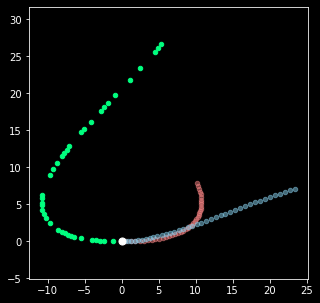

------------ 4 + 5 -----------
[[0.09984397]]
[[0.23392298]]
[[0.19968795]]
-----------------------
[[0.09705097]]
[[0.12940314]]
[[0.22645411]]
[[0.23017917]]
-----------------------
[[0.09994345]]
[[0.10282833]]
[[0.10627493]]
[[0.10998471]]
[[0.11229609]]
[[0.11682901]]
[[0.12037414]]
[[0.12505298]]
[[0.12709949]]
[[0.13103744]]
[[0.13275775]]
[[0.13742882]]
[[0.1422307]]
[[0.14425762]]
[[0.14707748]]
[[0.14976001]]
[[0.1542471]]
[[0.1557549]]
[[0.1618522]]
[[0.16529688]]
[[0.16868637]]
[[0.17352561]]
[[0.17794379]]
[[0.17792193]]
[[0.18310869]]
[[0.18529154]]
[[0.19149392]]
[[0.19254704]]
[[0.19511508]]
[[0.20214323]]
[[0.20312422]]
[[0.20826093]]
[[0.21101132]]
[[0.21302601]]
[[0.21207959]]
[[0.2182365]]
[[0.21998534]]
[[0.22309735]]
[[0.22688857]]
[[0.23432502]]
[[0.2314819]]
[[0.23715211]]
[[0.24341262]]
[[0.24413132]]
[[0.24407655]]
[[0.24325889]]
[[0.24890417]]
[[0.24868117]]
[[0.2553887]]
[[0.25471687]]
[[0.26662722]]
[[0.25818772]]
[[0.26536839]]
[[0.26758396]]
[[0.27020247]

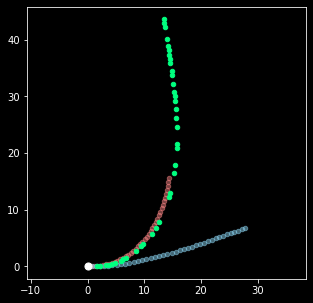

------------ 4 + 5 -----------
[[0.15978903]]
[[0.34357588]]
[[0.31957807]]
-----------------------
[[0.15501099]]
[[0.17909731]]
[[0.3341083]]
[[0.33857858]]
-----------------------
[[0.15938453]]
[[0.16399423]]
[[0.16862953]]
[[0.17520656]]
[[0.17909687]]
[[0.18292168]]
[[0.18945755]]
[[0.19482175]]
[[0.19962833]]
[[0.20342966]]
[[0.20811863]]
[[0.21390511]]
[[0.21961045]]
[[0.22475614]]
[[0.22971584]]
[[0.2364594]]
[[0.24054188]]
[[0.24637786]]
[[0.24972608]]
[[0.25545821]]
[[0.25844214]]
[[0.2642316]]
[[0.26774403]]
[[0.27258918]]
[[0.28078583]]
[[0.28407603]]
[[0.29176471]]
[[0.28886796]]
[[0.29352882]]
[[0.29889401]]
[[0.3009186]]
[[0.30795451]]
[[0.31016254]]
[[0.31039626]]
[[0.32348207]]
[[0.32040722]]
[[0.32538272]]
[[0.33231368]]
[[0.32783691]]
[[0.33759677]]
[[0.33565315]]
[[0.34750876]]
[[0.34556209]]
[[0.3483055]]
[[0.35409155]]
[[0.3567419]]
[[0.35924869]]
[[0.37002128]]
[[0.36684327]]
[[0.36706198]]
[[0.37429938]]
[[0.38352853]]
[[0.37445038]]
[[0.38041224]]
[[0.3885812]

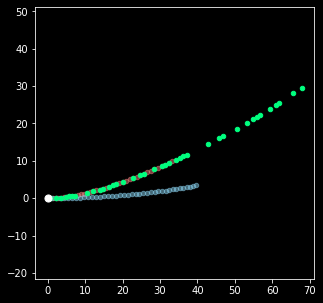

------------ 4 + 5 -----------
[[0.16786254]]
[[0.31787322]]
[[0.33572508]]
-----------------------
[[0.16442472]]
[[0.14474448]]
[[0.3091692]]
[[0.31003074]]
-----------------------
[[0.16786254]]
[[0.17238755]]
[[0.17547428]]
[[0.17916457]]
[[0.18318323]]
[[0.18640091]]
[[0.1896995]]
[[0.19405835]]
[[0.19907478]]
[[0.2006948]]
[[0.20961535]]
[[0.21316427]]
[[0.21891775]]
[[0.22186865]]
[[0.22577411]]
[[0.23064721]]
[[0.2348262]]
[[0.23838807]]
[[0.24084301]]
[[0.24483778]]
[[0.24947622]]
[[0.25388618]]
[[0.25743677]]
[[0.26069125]]
[[0.26407467]]
[[0.26794302]]
[[0.27103952]]
[[0.27227088]]
[[0.27783233]]
[[0.27988299]]
[[0.28407251]]
[[0.28826925]]
[[0.29094263]]
[[0.29505668]]
[[0.29780179]]
[[0.30151877]]
[[0.30544852]]
[[0.30782981]]
[[0.31080419]]
[[0.31374297]]
[[0.31615189]]
[[0.31966505]]
[[0.32230441]]
[[0.32553765]]
[[0.32788351]]
[[0.33187855]]
[[0.3347558]]
[[0.33701838]]
[[0.33857891]]
[[0.34405438]]
[[0.34415457]]
[[0.34853166]]
[[0.34983709]]
[[0.35303746]]
[[0.3565406

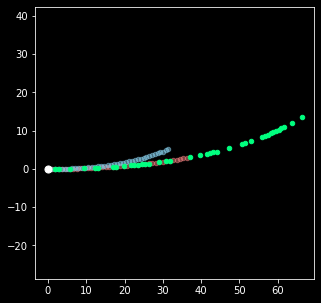

------------ 4 + 5 -----------
[[0.17221355]]
[[0.33295459]]
[[0.34442711]]
-----------------------
[[0.16820746]]
[[0.15668777]]
[[0.32489523]]
[[0.32485034]]
-----------------------
[[0.17236541]]
[[0.17657259]]
[[0.18084777]]
[[0.18602193]]
[[0.18999388]]
[[0.19376368]]
[[0.19838696]]
[[0.20311177]]
[[0.20661424]]
[[0.21446767]]
[[0.21742173]]
[[0.22493191]]
[[0.22908159]]
[[0.23258885]]
[[0.23631924]]
[[0.24202613]]
[[0.24650425]]
[[0.2484417]]
[[0.25285974]]
[[0.25747164]]
[[0.25839487]]
[[0.26635515]]
[[0.2707677]]
[[0.2724674]]
[[0.27751231]]
[[0.28233634]]
[[0.28607291]]
[[0.28887085]]
[[0.29278511]]
[[0.29724184]]
[[0.30231209]]
[[0.30396814]]
[[0.30749333]]
[[0.31166002]]
[[0.31201506]]
[[0.31797027]]
[[0.32117459]]
[[0.32134739]]
[[0.32888604]]
[[0.32777212]]
[[0.33222854]]
[[0.33542539]]
[[0.33583976]]
[[0.3406049]]
[[0.34473689]]
[[0.34791798]]
[[0.35013202]]
[[0.35226514]]
[[0.35745348]]
[[0.35839888]]
[[0.36496772]]
[[0.36336857]]
[[0.36643948]]
[[0.36888684]]
[[0.372049

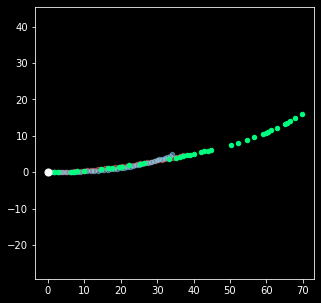

------------ 4 + 5 -----------
[[0.10061633]]
[[0.18894934]]
[[0.20123265]]
-----------------------
[[0.09876839]]
[[0.08182044]]
[[0.18058883]]
[[0.18055275]]
-----------------------
[[0.10136556]]
[[0.10416136]]
[[0.10682388]]
[[0.1098999]]
[[0.11229747]]
[[0.11464502]]
[[0.11674803]]
[[0.1203106]]
[[0.12149048]]
[[0.12466751]]
[[0.12630006]]
[[0.13032833]]
[[0.13101657]]
[[0.1341621]]
[[0.13649411]]
[[0.13767858]]
[[0.14236224]]
[[0.14256461]]
[[0.14588388]]
[[0.1463517]]
[[0.15098598]]
[[0.15464513]]
[[0.15503809]]
[[0.1587086]]
[[0.15923169]]
[[0.16460026]]
[[0.16493557]]
[[0.1679444]]
[[0.16858329]]
[[0.16951046]]
[[0.16827422]]
[[0.17551603]]
[[0.17401043]]
[[0.17171327]]
[[0.1716871]]
[[0.17908955]]
[[0.17927903]]
[[0.17872829]]
[[0.18210545]]
[[0.18468779]]
[[0.1845717]]
[[0.1844571]]
[[0.18148789]]
[[0.18984796]]
[[0.1881707]]
[[0.18659131]]
[[0.19082077]]
[[0.19344975]]
[[0.19664474]]
[[0.198764]]
[[0.19986624]]
[[0.20178032]]
[[0.19885109]]
[[0.19987163]]
[[0.20760446]]
[[0

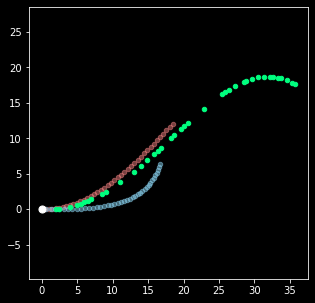

------------ 4 + 5 -----------
[[0.09996268]]
[[0.23897614]]
[[0.19992537]]
-----------------------
[[0.09654038]]
[[0.13473063]]
[[0.23127101]]
[[0.23112072]]
-----------------------
[[0.09974668]]
[[0.10274534]]
[[0.10638779]]
[[0.109911]]
[[0.1109899]]
[[0.11559509]]
[[0.11911184]]
[[0.12218171]]
[[0.12651095]]
[[0.1290704]]
[[0.13293929]]
[[0.13403095]]
[[0.13958939]]
[[0.14336264]]
[[0.14513294]]
[[0.14828584]]
[[0.15348856]]
[[0.15423144]]
[[0.16099332]]
[[0.16697067]]
[[0.16775004]]
[[0.17505524]]
[[0.18082433]]
[[0.1796668]]
[[0.18526366]]
[[0.18979143]]
[[0.19350441]]
[[0.19309548]]
[[0.19527233]]
[[0.20132823]]
[[0.20513964]]
[[0.20911462]]
[[0.21256395]]
[[0.21783907]]
[[0.21786023]]
[[0.22297398]]
[[0.22431486]]
[[0.22580475]]
[[0.2305384]]
[[0.23692039]]
[[0.23588181]]
[[0.24045379]]
[[0.24353053]]
[[0.24745515]]
[[0.24898632]]
[[0.25302908]]
[[0.2558692]]
[[0.2553629]]
[[0.26440313]]
[[0.26417117]]
[[0.26976938]]
[[0.27164805]]
[[0.27242745]]
[[0.27837744]]
[[0.27920426]]

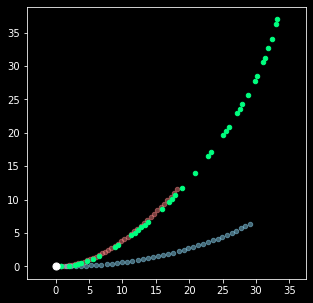

------------ 4 + 5 -----------
[[0.09741141]]
[[0.25232999]]
[[0.19482281]]
-----------------------
[[0.09346626]]
[[0.15369068]]
[[0.24715694]]
[[0.25535016]]
-----------------------
[[0.09788209]]
[[0.10096062]]
[[0.10720897]]
[[0.10964322]]
[[0.11378954]]
[[0.11976291]]
[[0.12534597]]
[[0.12410896]]
[[0.13217489]]
[[0.13568573]]
[[0.13861988]]
[[0.14622244]]
[[0.15316834]]
[[0.15560016]]
[[0.16082666]]
[[0.16434953]]
[[0.16763864]]
[[0.1729179]]
[[0.17979565]]
[[0.1789301]]
[[0.18706092]]
[[0.19155752]]
[[0.19190574]]
[[0.19478526]]
[[0.20190667]]
[[0.20227443]]
[[0.20626333]]
[[0.20731798]]
[[0.21318699]]
[[0.21581729]]
[[0.21908846]]
[[0.22159203]]
[[0.22608772]]
[[0.23778766]]
[[0.234385]]
[[0.23917276]]
[[0.24112593]]
[[0.24525735]]
[[0.24683298]]
[[0.24465822]]
[[0.25166583]]
[[0.25400466]]
[[0.26198598]]
[[0.26287759]]
[[0.26425073]]
[[0.26244465]]
[[0.26990666]]
[[0.27070898]]
[[0.27488032]]
[[0.27276348]]
[[0.27861855]]
[[0.28521309]]
[[0.27931886]]
[[0.28709639]]
[[0.288196

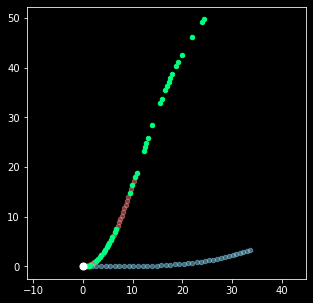

------------ 4 + 5 -----------
[[0.09165458]]
[[0.18163048]]
[[0.18330917]]
-----------------------
[[0.08952731]]
[[0.09470952]]
[[0.18423683]]
[[0.1863468]]
-----------------------
[[0.09206985]]
[[0.09401881]]
[[0.09514851]]
[[0.09795156]]
[[0.10009555]]
[[0.10357485]]
[[0.10512446]]
[[0.10702977]]
[[0.10957464]]
[[0.11283558]]
[[0.11311603]]
[[0.11665032]]
[[0.11916335]]
[[0.12182943]]
[[0.12403207]]
[[0.12759868]]
[[0.12777658]]
[[0.13004471]]
[[0.13306504]]
[[0.13447881]]
[[0.13829322]]
[[0.14319426]]
[[0.14633406]]
[[0.14527423]]
[[0.15094902]]
[[0.15438766]]
[[0.1548208]]
[[0.15846324]]
[[0.16085046]]
[[0.16276255]]
[[0.16584739]]
[[0.16948686]]
[[0.17147265]]
[[0.17531138]]
[[0.17751346]]
[[0.17950472]]
[[0.17892066]]
[[0.18145032]]
[[0.18051722]]
[[0.18674875]]
[[0.18480488]]
[[0.18628295]]
[[0.18846527]]
[[0.19009062]]
[[0.19322552]]
[[0.19494291]]
[[0.19911761]]
[[0.19483253]]
[[0.19722608]]
[[0.21080734]]
[[0.20921848]]
[[0.21090682]]
[[0.20995265]]
[[0.21299328]]
[[0.2155

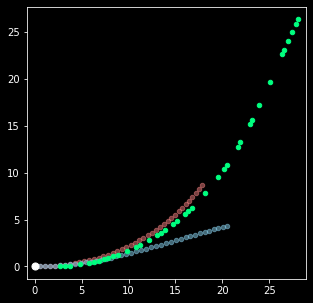

In [31]:
sample_points = 40
supporting_points_count = 40
max_offset = 4
limit = 40
numpy.random.seed(60)

torch.set_default_dtype(torch.float64)
device = torch.device('cuda')
model = DeepSignatureArcLengthNet(sample_points=sample_points).cuda()
model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
# model.load_state_dict(torch.load("C:/deep-signature-data/level-curves/results/tuplets/arclength/2021-01-14-02-42-52/model_349.pt", map_location=device))
model.eval()

curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
numpy.random.shuffle(curves)
curves = curves[:limit]
color_map = plt.get_cmap('rainbow', limit)

for curve_index, curve in enumerate(curves):
    if curve_index == 25:
        break
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.axis('equal')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)

    # for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    #     label.set_fontsize(30)

    # for label in (ax[2].get_xticklabels() + ax[2].get_yticklabels()):
    #     label.set_fontsize(30)    

    # plot curve
    # plot_curve(ax=ax[0], curve=curve, color=color_map(curve_index), linewidth=5)

    # plot predicted curvature
    predicted_arclength = numpy.zeros(curve.shape[0])
    for i in range(curve.shape[0]):
        if i == 1:
            break

        # sample = curve_sampling.sample_curve_section(
        #     curve=curve,
        #     supporting_points_count=supporting_points_count,
        #     start_point_index=i,
        #     end_point_index=i+supporting_points_count)
        # sample = curve_processing.normalize_curve(curve=sample, force_ccw=False, index1=0, index2=1, center_index=0)
        # batch_data = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample).double(), dim=0), dim=0).cuda()
        # with torch.no_grad():
        #     predicted_arclength[i] = torch.squeeze(model(batch_data), dim=0).cpu().detach().numpy()


        sample1_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i,
            end_point_index=i+supporting_points_count - 1)
        sample1 = curve_processing.normalize_curve(curve=sample1_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data1 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample1).double(), dim=0), dim=0).cuda()

        sample2_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i+supporting_points_count - 1,
            end_point_index=i+2*supporting_points_count - 2)
        sample2 = curve_processing.normalize_curve(curve=sample2_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data2 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample2).double(), dim=0), dim=0).cuda()

        sample3_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i,
            end_point_index=i+2*supporting_points_count - 2)
        sample3 = curve_processing.normalize_curve(curve=sample3_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data3 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample3).double(), dim=0), dim=0).cuda()










        sample4_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i,
            end_point_index=i+supporting_points_count)
        sample4 = curve_processing.normalize_curve(curve=sample4_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data4 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample4).double(), dim=0), dim=0).cuda()

        sample5_org = curve_sampling.sample_curve_section(
            curve=curve,
            supporting_points_count=sample_points,
            start_point_index=i,
            end_point_index=i+2*supporting_points_count)
        sample5 = curve_processing.normalize_curve(curve=sample5_org, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
        batch_data5 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample5).double(), dim=0), dim=0).cuda()


        print('------------ 4 + 5 -----------')
        with torch.no_grad():
            s1 = torch.squeeze(model(batch_data4), dim=0).cpu().detach().numpy()
            s2 = torch.squeeze(model(batch_data5), dim=0).cpu().detach().numpy()
            print(s1)
            print(s2)
            print(2 * s1)
            print('-----------------------')








        plot_sample(
            ax=ax, 
            sample=sample1, 
            point_size=20,
            color='lightcoral',
            alpha=0.5,
            zorder=50)

        plot_sample(
            ax=ax, 
            sample=sample2, 
            point_size=20,
            color='skyblue',
            alpha=0.5,
            zorder=50)

        plot_sample(
            ax=ax, 
            sample=sample3, 
            point_size=20,
            color='springgreen',
            zorder=150)

        plot_sample(ax, numpy.array([[sample1[0,0] ,sample1[0, 1]]]), point_size=50, alpha=1, color='white', zorder=200)

        with torch.no_grad():
            s1 = torch.squeeze(model(batch_data1), dim=0).cpu().detach().numpy()
            s2 = torch.squeeze(model(batch_data2), dim=0).cpu().detach().numpy()
            s3 = torch.squeeze(model(batch_data3), dim=0).cpu().detach().numpy()
            print(s1)
            print(s2)
            print(s1+s2)
            print(s3)
            print('-----------------------')







        for j in range(60):
            sample1 = curve_sampling.sample_curve_section2(
                curve=curve,
                supporting_points_count=sample_points,
                start_point_index=i,
                end_point_index=i+supporting_points_count + j)
            sample1 = curve_processing.normalize_curve(curve=sample1, force_ccw=False, force_end_point=True, index1=0, index2=1, center_index=0)
            batch_data1 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample1).double(), dim=0), dim=0).cuda()
            with torch.no_grad():
                s1 = torch.squeeze(model(batch_data1), dim=0).cpu().detach().numpy()
                print(s1)
            
        print('-----------------------')




    # plot_curvature(ax=ax[1], curvature=predicted_curvature, color=color_map(curve_index), linewidth=5)

    # plot ground-truth curvature
    # gt_arclength = curve_processing.calculate_arclength(curve=curve)
    # plot_curvature(ax=ax[2], curvature=gt_arclength, color=color_map(curve_index), linewidth=5)

    plt.show()